# Tutorial:RNA+ADT (well-labeled)

In this tutorial, we will show how to cluster RNA+ADT(well-labeled) data using scMAGCA. As an example, we use a paired human peripheral blood sample dataset '10X1kpbmc' containing 713 cells with two omics. Among them, ADT has 17 features, while RNA contains 33,538 features.

## Loading package

In [1]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import random
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from scMAGCA.preprocess import read_dataset, preprocess_dataset
from scMAGCA.utils import *
from scMAGCA.scMAGCA import scMultiCluster

In [3]:
# set seed
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

## Reading dataset

The required input files include: 
1) x1: protein abundance matrix (data format is h5ad file) : 10X1kpbmc_adt.h5ad; \
2) x2: Gene expression matrix (data format is h5ad file) : 10X1kpbmc_rna.h5ad; \
3) Real label (stored as csv file) : 10X1kpbmc_label.csv.

To ensure reproducibility of the results, please read the above data as follows:

In [7]:
x1 = np.array(sc.read_h5ad('../datasets/10Xmalt/10Xmalt_adt.h5ad').to_df()).astype('float32')
x2 = np.array(sc.read_h5ad('../datasets/10Xmalt/10Xmalt_rna.h5ad').to_df()).astype('float32')
y = np.array(pd.read_csv('../datasets/10Xmalt/10Xmalt_label.csv')['Cluster']).astype('float32')

In [6]:
x1,x2,y

(array([[1.500e+01, 1.600e+01, 9.000e+00, ..., 1.100e+01, 1.900e+01,
         4.000e+00],
        [1.900e+01, 2.200e+01, 1.400e+01, ..., 1.000e+01, 1.200e+01,
         6.000e+00],
        [3.830e+03, 2.791e+03, 2.500e+01, ..., 1.100e+01, 1.100e+01,
         3.000e+00],
        ...,
        [1.000e+01, 1.400e+01, 4.000e+00, ..., 8.000e+00, 1.300e+01,
         3.000e+00],
        [1.100e+01, 2.500e+01, 7.000e+00, ..., 5.000e+00, 1.100e+01,
         4.000e+00],
        [6.100e+01, 6.710e+02, 2.900e+01, ..., 2.400e+01, 1.800e+01,
         7.000e+00]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([1., 5., 3., ..., 1., 1., 5.], dtype=float32))

Due to the small number of features in ADT omics data and the large gap between the feature dimensions of RNA omics, for RNA+ADT data, we only select high-expression features for RNA omics (the default number of chosen genes is 2000).

Chosen offset: 0.21


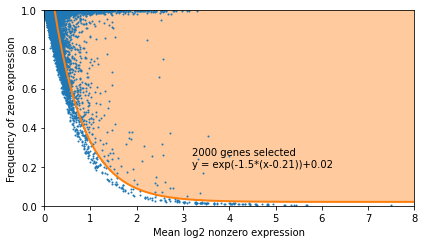

In [7]:
importantGenes = geneSelection(x2, n=2000)
x2 = x2[:, importantGenes]

In [8]:
adata1 = sc.AnnData(x1)
adata1 = read_dataset(adata1, copy=True)
adata1 = preprocess_dataset(adata1, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 17 features and 8412 cells.


In [9]:
adata1

AnnData object with n_obs × n_vars = 8412 × 17
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

In [10]:
adata2 = sc.AnnData(x2)
adata2 = read_dataset(adata2, copy=True)
adata2 = preprocess_dataset(adata2, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 2000 features and 8412 cells.


In [11]:
adata2

AnnData object with n_obs × n_vars = 8412 × 2000
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

## Training the model

Our model training is divided into two stages: pre-training stage and formal training stage. The number of epochs in the pre-training phase is set to 400, while the number in the formal training is 2000. In formal training, if the change in training results reaches a set threshold, it will end early. <br>

After the training, the potential representations and predicted label values obtained by scMAGCA are saved to the corresponding folder of the data set and can be used for subsequent downstream analysis.

In [12]:
model = scMultiCluster(input_dim1=adata1.n_vars,input_dim2=adata2.n_vars,device='cuda').to('cuda')

In [13]:
model

scMultiCluster(
  (encoder): Encoder(
    (stacked_gnn): ModuleList(
      (0): GCNConv(2017, 1024)
      (1): GCNConv(1024, 256)
      (2): GCNConv(256, 64)
      (3): GCNConv(64, 32)
    )
    (stacked_bns): ModuleList(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (3): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
    (stacked_prelus): ModuleList(
      (0-3): 4 x PReLU(num_parameters=1)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, moment

In [16]:
pretrain_latent = model.pretrain_autoencoder(
                        X1=adata1.X, X2=adata2.X, X1_raw=adata1.raw.X, X2_raw=adata2.raw.X, 
                        epochs=400, file='10Xmalt')

Pretraining stage


Processing...
Done!


Processing full batch data
Pretrain epoch 1, recon_loss:0.649600, zinb_loss:0.334276, adversial_loss:1.387772
Pretrain epoch 2, recon_loss:1.166402, zinb_loss:0.399252, adversial_loss:1.383057
Pretrain epoch 3, recon_loss:0.904996, zinb_loss:0.355427, adversial_loss:1.379536
Pretrain epoch 4, recon_loss:0.823846, zinb_loss:0.345058, adversial_loss:1.383288
Pretrain epoch 5, recon_loss:0.819289, zinb_loss:0.346134, adversial_loss:1.385502
Pretrain epoch 6, recon_loss:0.791929, zinb_loss:0.346356, adversial_loss:1.386828
Pretrain epoch 7, recon_loss:0.768622, zinb_loss:0.344677, adversial_loss:1.387559
Pretrain epoch 8, recon_loss:0.758853, zinb_loss:0.343187, adversial_loss:1.387539
Pretrain epoch 9, recon_loss:0.756376, zinb_loss:0.342421, adversial_loss:1.386914
Pretrain epoch 10, recon_loss:0.752964, zinb_loss:0.341971, adversial_loss:1.386105
Pretrain epoch 11, recon_loss:0.747530, zinb_loss:0.341533, adversial_loss:1.385441
Pretrain epoch 12, recon_loss:0.741816, zinb_loss:0.341144

Pretrain epoch 101, recon_loss:0.640522, zinb_loss:0.331865, adversial_loss:1.360754
Pretrain epoch 102, recon_loss:0.641382, zinb_loss:0.331850, adversial_loss:1.360472
Pretrain epoch 103, recon_loss:0.641516, zinb_loss:0.331848, adversial_loss:1.360390
Pretrain epoch 104, recon_loss:0.642772, zinb_loss:0.331859, adversial_loss:1.359993
Pretrain epoch 105, recon_loss:0.641917, zinb_loss:0.331840, adversial_loss:1.359989
Pretrain epoch 106, recon_loss:0.639695, zinb_loss:0.331789, adversial_loss:1.359644
Pretrain epoch 107, recon_loss:0.639391, zinb_loss:0.331756, adversial_loss:1.359257
Pretrain epoch 108, recon_loss:0.638370, zinb_loss:0.331705, adversial_loss:1.359387
Pretrain epoch 109, recon_loss:0.639193, zinb_loss:0.331703, adversial_loss:1.359058
Pretrain epoch 110, recon_loss:0.640983, zinb_loss:0.331697, adversial_loss:1.358626
Pretrain epoch 111, recon_loss:0.639744, zinb_loss:0.331649, adversial_loss:1.358537
Pretrain epoch 112, recon_loss:0.638249, zinb_loss:0.331630, adve

Pretrain epoch 201, recon_loss:0.615736, zinb_loss:0.329868, adversial_loss:1.341789
Pretrain epoch 202, recon_loss:0.613637, zinb_loss:0.329809, adversial_loss:1.341829
Pretrain epoch 203, recon_loss:0.615342, zinb_loss:0.329883, adversial_loss:1.341577
Pretrain epoch 204, recon_loss:0.617325, zinb_loss:0.329926, adversial_loss:1.341484
Pretrain epoch 205, recon_loss:0.616907, zinb_loss:0.329901, adversial_loss:1.341250
Pretrain epoch 206, recon_loss:0.613431, zinb_loss:0.329809, adversial_loss:1.341080
Pretrain epoch 207, recon_loss:0.612470, zinb_loss:0.329729, adversial_loss:1.341008
Pretrain epoch 208, recon_loss:0.611814, zinb_loss:0.329767, adversial_loss:1.340827
Pretrain epoch 209, recon_loss:0.611253, zinb_loss:0.329767, adversial_loss:1.340662
Pretrain epoch 210, recon_loss:0.610531, zinb_loss:0.329709, adversial_loss:1.340472
Pretrain epoch 211, recon_loss:0.613676, zinb_loss:0.329733, adversial_loss:1.340483
Pretrain epoch 212, recon_loss:0.617048, zinb_loss:0.329781, adve

Pretrain epoch 301, recon_loss:0.595029, zinb_loss:0.328846, adversial_loss:1.329205
Pretrain epoch 302, recon_loss:0.593424, zinb_loss:0.328757, adversial_loss:1.328737
Pretrain epoch 303, recon_loss:0.588343, zinb_loss:0.328616, adversial_loss:1.328792
Pretrain epoch 304, recon_loss:0.588452, zinb_loss:0.328673, adversial_loss:1.328775
Pretrain epoch 305, recon_loss:0.589866, zinb_loss:0.328618, adversial_loss:1.328277
Pretrain epoch 306, recon_loss:0.587268, zinb_loss:0.328578, adversial_loss:1.328775
Pretrain epoch 307, recon_loss:0.587211, zinb_loss:0.328587, adversial_loss:1.328083
Pretrain epoch 308, recon_loss:0.588906, zinb_loss:0.328546, adversial_loss:1.328236
Pretrain epoch 309, recon_loss:0.592827, zinb_loss:0.328610, adversial_loss:1.328219
Pretrain epoch 310, recon_loss:0.593601, zinb_loss:0.328605, adversial_loss:1.327819
Pretrain epoch 311, recon_loss:0.589352, zinb_loss:0.328540, adversial_loss:1.327900
Pretrain epoch 312, recon_loss:0.587281, zinb_loss:0.328458, adve

In [ ]:
y_pred, final_latent = model.fit(y=y, n_clusters=11, file='10Xmalt')

In [ ]:
import numpy as np

y_pred_ = best_map(y, y_pred).astype(int)
np.savetxt("../results/10Xmalt_pred.csv", y_pred, delimiter=",")
np.savetxt("../results/10Xmalt_embedding.csv", final_latent.cpu().detach().numpy(), delimiter=",")

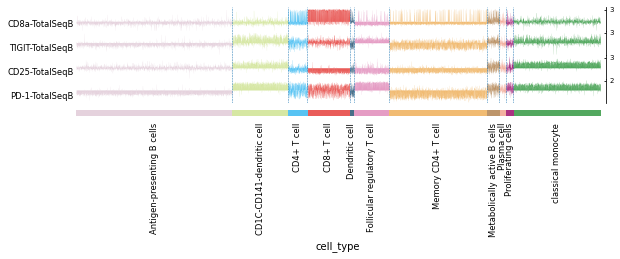

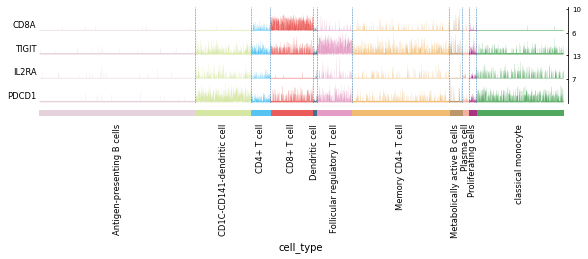

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

x1 = np.array(sc.read_h5ad('../datasets/10Xmalt/10Xmalt_adt.h5ad').to_df()).astype('float32')
feature1 = sc.read_h5ad('../datasets/10Xmalt/10Xmalt_adt.h5ad').var['features'].index
x2 = np.array(sc.read_h5ad('../datasets/10Xmalt/10Xmalt_rna.h5ad').to_df()).astype('float32')
feature2 = sc.read_h5ad('../datasets/10Xmalt/10Xmalt_rna.h5ad').var['features'].index
cell_type = np.array(pd.read_csv('../scripts/10Xmlat/10Xmalt_pred.csv',header=None).astype('int').iloc[:,0]).astype('str')


dic = {'1':'Antigen-presenting B cells',
       '2':'classical monocyte',
       '3':'Memory CD4+ T cell',
       '4':'Plasma cell',
       '5':'CD1C-CD141-dendritic cell',
       '6':'CD4+ T cell',
       '7':'CD8+ T cell',
       '8':'Dendritic cell',
       '9':'Follicular regulatory T cell',
       '10':'Proliferating cells',
       '11':'Metabolically active B cells'}
cell_type = [dic[i] for i in cell_type]
#print(cell_type)

adata_ADT = sc.AnnData(x1)
sc.pp.normalize_total(adata_ADT)
sc.pp.log1p(adata_ADT)
sc.pp.scale(adata_ADT)
adata_ADT.var_names = feature1
adata_ADT.obs['cell_type'] = cell_type
adata_ADT.obs['cell_type'] = adata_ADT.obs['cell_type'].astype('category')
adata_RNA = sc.AnnData(x2)
sc.pp.normalize_total(adata_RNA)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA)
adata_RNA.var_names = feature2
adata_RNA.obs['cell_type'] = cell_type
adata_RNA.obs['cell_type'] = adata_RNA.obs['cell_type'].astype('category')


adt_list = ['CD8a-TotalSeqB','TIGIT-TotalSeqB','CD25-TotalSeqB', 'PD-1-TotalSeqB']
gene_list = ['CD8A','TIGIT','IL2RA', 'PDCD1']

#colors = ["#CDDEB7FF", "#E4AF69FF", "#5DB1DDFF", "#CE3D32FF", "#3C5488FF", "#809900FF", "#B09C85FF", "#996600FF", "#BA6338FF", "#466983FF", "#111983FF"]
colors = ['#E5D2DD', '#D6E7A3', '#57C3F3', '#E95C59', '#476D87', '#E59CC4', '#F1BB72', '#BD956A', '#F3B1A0', '#AB3282', "#53A85F"]
cmap = ListedColormap(colors)

adata_ADT.uns['cell_type_colors']=colors
adata_RNA.uns['cell_type_colors']=colors

sc.pl.tracksplot(adata_ADT, var_names = adt_list, groupby='cell_type', figsize=[10,2], save='adt_norm.pdf', **{'cmap': cmap})
sc.pl.tracksplot(adata_RNA, var_names = gene_list, groupby='cell_type', figsize=[10,2], save='rna_norm.pdf', **{'cmap': cmap})

In [30]:
library(anndata)
library(reticulate)
library(dplyr)
library(tidyr)
library(Seurat)
library(ggplot2)

In [31]:
use_condaenv("/home/zhouzeming/anaconda3")

In [32]:
sys <- import("sys")

In [33]:
ad <- import("anndata")

In [34]:
adt <- ad$read_h5ad('../datasets/10Xmalt/10xmalt_adt.h5ad')
rna <- ad$read_h5ad('../datasets/10Xmalt/10xmalt_rna.h5ad')

scRNA.adt <- adt$X
scRNA.rna <- rna$X

mycolors <- c('Antigen-presenting B cells'='#E5D2DD', 'classical monocyte'='#53A85F','Memory CD4+ T cell'='#F1BB72',
             'Plasma cell'='#F3B1A0','CD1C-CD141-dendritic cell'='#D6E7A3', 'CD4+ T cell'='#57C3F3', 'CD8+ T cell'='#E95C59',
             'Dendritic cell'='#476D87','Follicular regulatory T cell'='#E59CC4','Proliferating cells'='#AB3282','Metabolically active B cells'='#BD956A')

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:34:26 UMAP embedding parameters a = 0.9922 b = 1.112

11:34:26 Read 8412 rows and found 30 numeric columns

11:34:26 Using Annoy for neighbor search, n_neighbors = 30

11:34:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:34:27 Writing NN index 

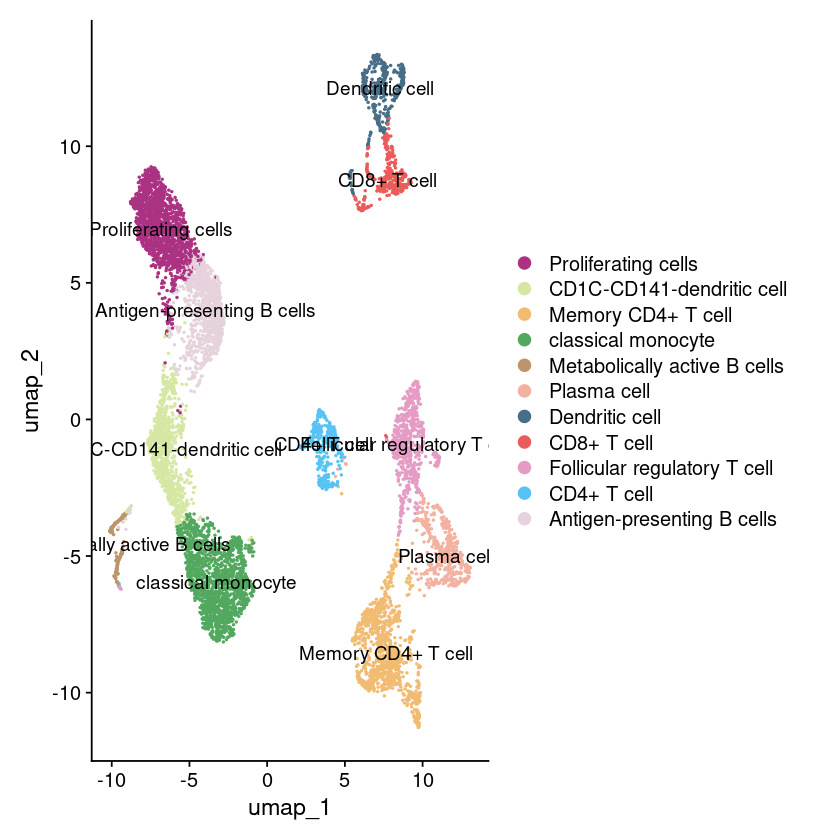

In [54]:
ADT <- CreateSeuratObject(counts = t(scRNA.adt),project ="ADT",min.cells = 3)
ADT_label <- read.csv("../scripts/10Xmalt/adt_pred.csv",header = F)
ADT@meta.data$clusters <- ADT_label
Idents(ADT) <- as.factor(ADT_label$V1)
ADT <- NormalizeData(ADT, normalization.method = "LogNormalize")
ADT <- FindVariableFeatures(ADT, selection.method = "vst", nfeatures = 2000) 
ADT <- ScaleData(ADT, features = rownames(ADT))
ADT_mds<- read.csv('..scripts/10Xmalt/adt_embedding.csv',row.names=1)
ADT_mds <- as.matrix(ADT_mds)
colnames(ADT_mds) <- paste0("MDS_", 1:32)
ADT[["mds"]] <- CreateDimReducObject(embeddings = ADT_mds, key = "MDS_", assay = DefaultAssay(ADT))
ADT <- RunUMAP(ADT,dims = 1:30,label=T,reduction = "mds")
new.cluster.ids <- c("Proliferating cells", "CD1C-CD141-dendritic cell", "Memory CD4+ T cell", "classical monocyte", "Metabolically active B cells", 
                     "Plasma cell", "Dendritic cell", "CD8+ T cell", "Follicular regulatory T cell", "CD4+ T cell", "Antigen-presenting B cells")
names(new.cluster.ids) <- levels(ADT)
ADT <- RenameIdents(ADT, new.cluster.ids)
ADT_umap <-DimPlot(ADT, reduction = "umap", label = TRUE, cols = mycolors)
ADT_umap

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
11:34:53 UMAP embedding parameters a = 0.9922 b = 1.112

11:34:53 Read 8412 rows and found 30 numeric columns

11:34:53 Using Annoy for neighbor search, n_neighbors = 30

11:34:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:34:54 Writing NN index file to temp file /tmp/Rtmp0dS1wi/file1aed8ea9e6a00

11:34:54 Searching Annoy index using 1 thread, search_k = 3000

11:34:57 Annoy recall = 100%

11:34:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:34:58 Initializing from normalized Lap

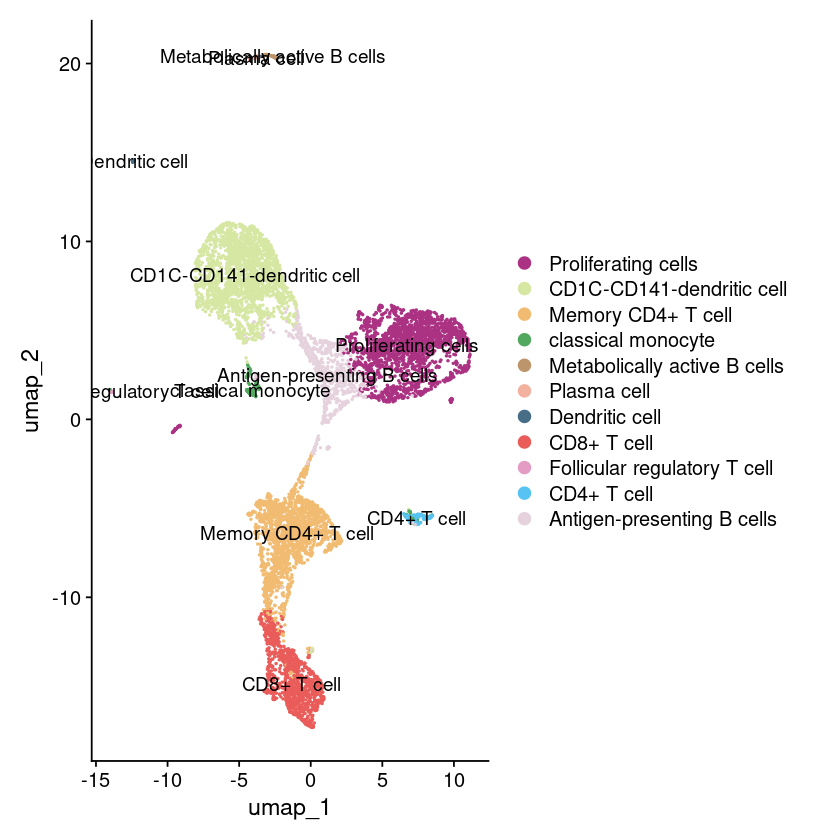

In [55]:
RNA <- CreateSeuratObject(counts = t(scRNA.rna),project ="RNA",min.cells = 3)
RNA_label <- read.csv("../scripts/10Xmalt/rna_pred.csv",header = F)
RNA@meta.data$clusters <- RNA_label
Idents(RNA) <- as.factor(RNA_label$V1)
RNA <- NormalizeData(RNA, normalization.method = "LogNormalize")
RNA <- FindVariableFeatures(RNA, selection.method = "vst", nfeatures = 2000) 
RNA <- ScaleData(RNA, features = rownames(RNA))
RNA_mds<- read.csv('../scripts/10Xmalt/rna_embedding.csv',row.names=1)
RNA_mds <- as.matrix(RNA_mds)
colnames(RNA_mds) <- paste0("MDS_", 1:32)
RNA[["mds"]] <- CreateDimReducObject(embeddings = RNA_mds, key = "MDS_", assay = DefaultAssay(RNA))
RNA <- RunUMAP(RNA,dims = 1:30,label=T,reduction = "mds")
new.cluster.ids <- c("Proliferating cells", "CD1C-CD141-dendritic cell", "Memory CD4+ T cell", "classical monocyte", "Metabolically active B cells", 
                     "Plasma cell", "Dendritic cell", "CD8+ T cell", "Follicular regulatory T cell", "CD4+ T cell", "Antigen-presenting B cells")
names(new.cluster.ids) <- levels(RNA)
RNA <- RenameIdents(RNA, new.cluster.ids)
RNA_umap <-DimPlot(RNA, reduction = "umap", label = TRUE, cols = mycolors)
RNA_umap

In [35]:
scRNA <- CreateSeuratObject(counts = t(scRNA.rna),project ="scRNA",min.cells = 3)
label <- read.csv("../scripts/10Xmalt/scMAGCA_pred.csv",header = F)
scRNA@meta.data$clusters <- label
Idents(scRNA) <- as.factor(label$V1)
scRNA <- NormalizeData(scRNA, normalization.method = "LogNormalize")
scRNA <- FindVariableFeatures(scRNA, selection.method = "vst", nfeatures = 2000) 
scRNA <- ScaleData(scRNA, features = rownames(scRNA))
all.genes <- rownames(scRNA)
variable.genes <- head(VariableFeatures(scRNA), 2000)
key.genes<- rownames(read.csv('../scripts/10Xmalt/key_genes.csv',row.names=1,header = F))

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



In [36]:
mds<- read.csv('../scripts/10Xmalt/scMAGCA_embedding.csv',row.names=1)
mds <- as.matrix(mds)
colnames(mds) <- paste0("MDS_", 1:32)
scRNA[["mds"]] <- CreateDimReducObject(embeddings = mds, key = "MDS_", assay = DefaultAssay(scRNA))
scRNA <- RunUMAP(scRNA,dims = 1:30,label=T,reduction = "mds")

Warning message:
“The following arguments are not used: label”
19:10:01 UMAP embedding parameters a = 0.9922 b = 1.112

19:10:01 Read 8412 rows and found 30 numeric columns

19:10:01 Using Annoy for neighbor search, n_neighbors = 30

19:10:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:10:02 Writing NN index file to temp file /tmp/RtmpcjASZF/file224f52091d059

19:10:02 Searching Annoy index using 1 thread, search_k = 3000

19:10:05 Annoy recall = 100%

19:10:06 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

19:10:07 Initializing from normalized Laplacian + noise (using RSpectra)

19:10:08 Commencing optimization for 500 epochs, with 328686 positive edges

19:10:08 Using rng type: pcg

19:10:18 Optimization finished



In [37]:
scRNA.markers <- FindAllMarkers(scRNA, 
                                ident.col = "clusters",
                                only.pos = T,  
                                min.pct = 0.25, 
                                logfc.threshold = 0.25,
                                features = variable.genes)
top.markers <- scRNA.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



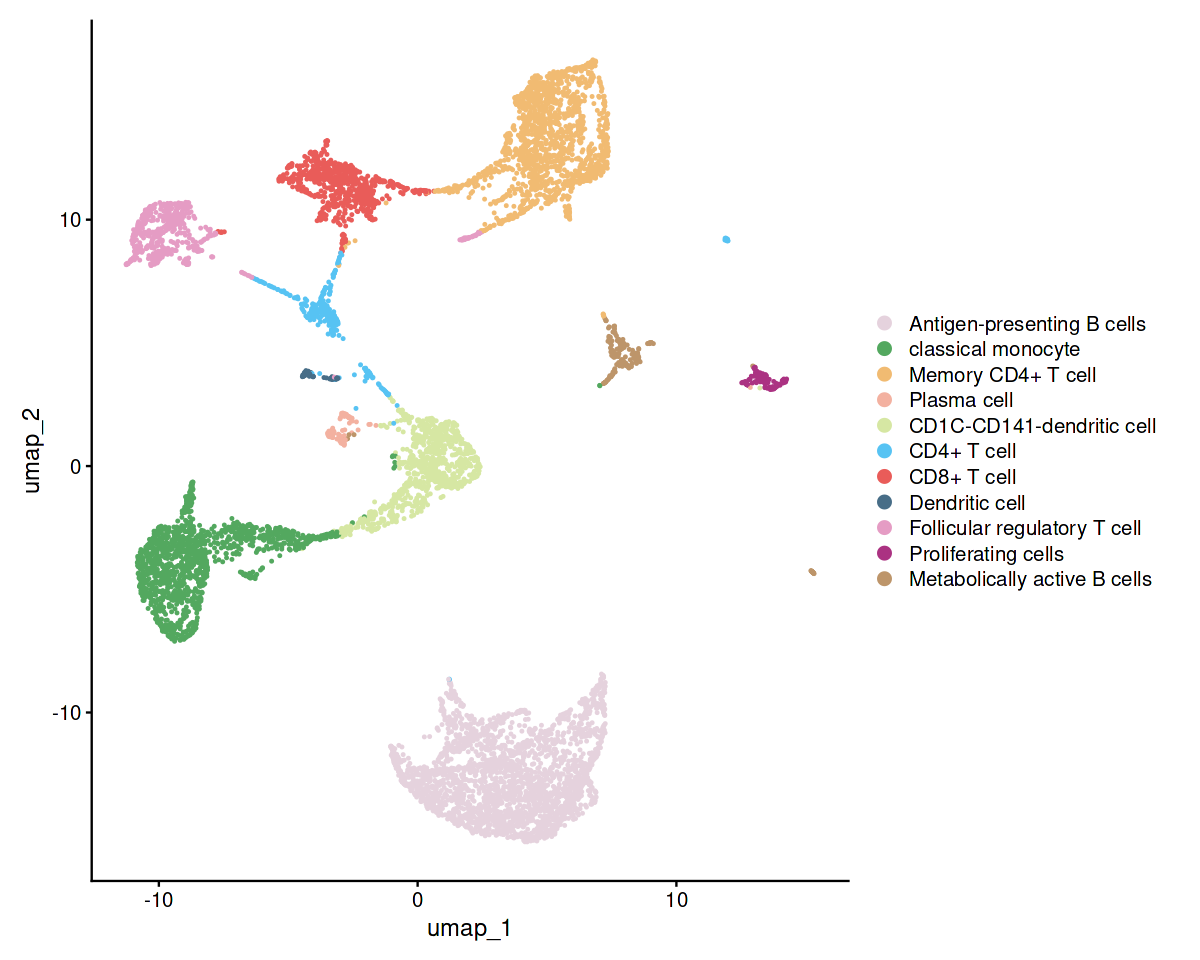

In [41]:
options(repr.plot.width = 10, repr.plot.height = 8)
new.cluster.ids <- c("Antigen-presenting B cells", "classical monocyte", "Memory CD4+ T cell", "Plasma cell", "CD1C-CD141-dendritic cell", 
                     "CD4+ T cell", "CD8+ T cell", "Dendritic cell", "Follicular regulatory T cell", "Proliferating cells", "Metabolically active B cells")
names(new.cluster.ids) <- levels(scRNA)
scRNA <- RenameIdents(scRNA, new.cluster.ids)
Joint_umap <-DimPlot(scRNA, reduction = "umap", label = FALSE, cols = mycolors)
Joint_umap

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


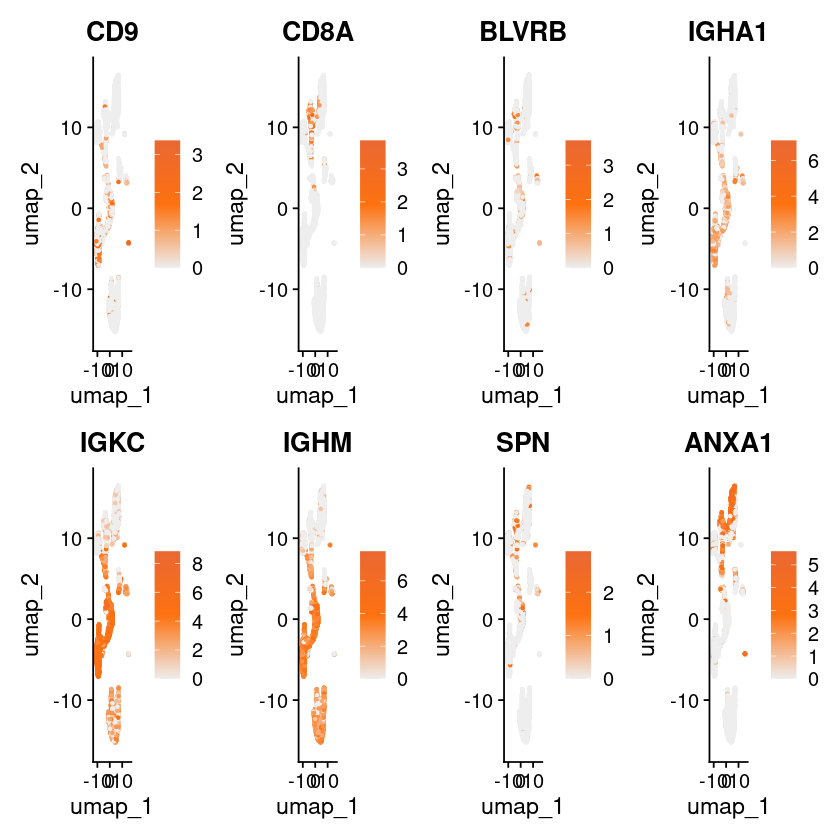

In [22]:
features <- c("CD9", "CD8A", "BLVRB", "IGHA1", "IGKC", "IGHM", "SPN", "ANXA1")
custom_colors <- colorRampPalette(c("#eeeeee", "#fe7210", "#ea6834"))(100)
plots <- list()
for (feature in features) {
  p <- FeaturePlot(scRNA, features = feature, reduction = "umap", pt.size = 0.5) +
    scale_colour_gradientn(colours = custom_colors)
  plots[[feature]] <- p
}
library(patchwork)
wrap_plots(plots) +  plot_layout(ncol = 4)

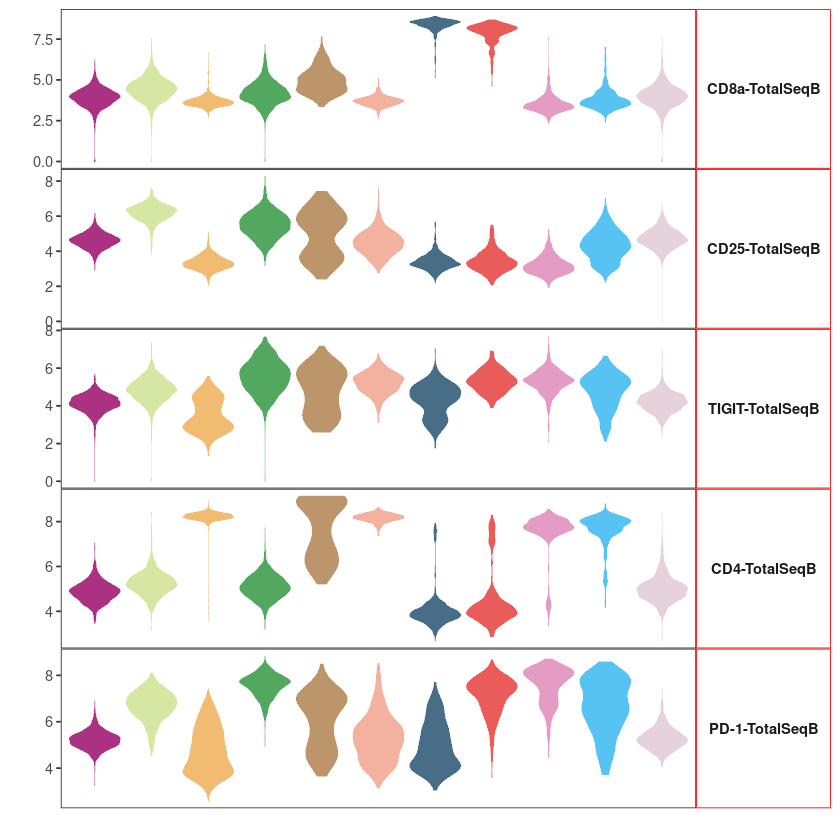

In [19]:
library(MySeuratWrappers)

markers <- c('CD8a-TotalSeqB','CD25-TotalSeqB', 'TIGIT-TotalSeqB', 'CD4-TotalSeqB', 'PD-1-TotalSeqB')

VlnPlot(ADT, features = markers, stacked=T, pt.size= 0, cols = mycolors, x.lab = '', y.lab = '') + 
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())

[1] 25236     3

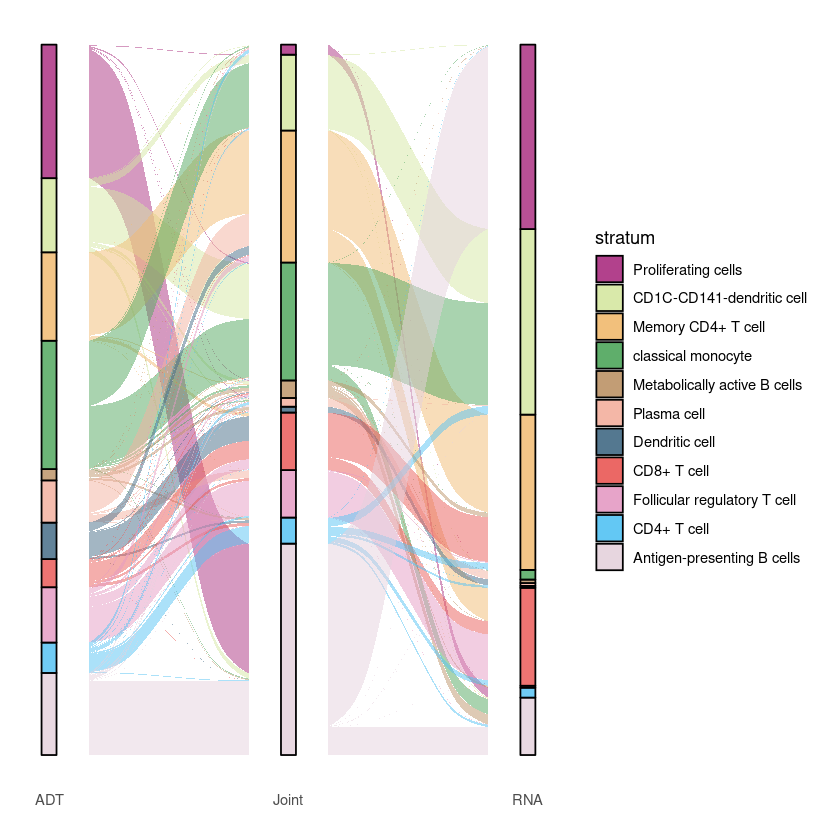

In [20]:
library(ggalluvial)
df <- data.frame(Idents(ADT),Idents(scRNA),Idents(RNA))
rownames(df) <- seq(1,length(Idents(scRNA)))
colnames(df) <- c('ADT','Joint','RNA')
corLodes <- to_lodes_form(df[,1:ncol(df)],
                          axes = 1:ncol(df),
                          id = "Cohort")
dim(corLodes)

ggplot(corLodes, 
       aes(x = x,
           stratum = stratum, 
           alluvium = Cohort,
           fill = stratum, 
           label = stratum))  +  
  geom_flow() + 
  geom_stratum(alpha = 0.85, width = 1/16) +
  scale_fill_manual(values = mycolors) +
  xlab("") +
  theme_bw() + 
  theme(axis.line = element_blank(),
        axis.ticks = element_blank(),
        axis.text.y = element_blank()) + 
  theme(panel.grid =element_blank()) + 
  theme(panel.border = element_blank()) + 
  scale_x_discrete(expand = c(0, 0))

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(key.genes, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = GO_database):
“4.1% of input gene IDs are fail to map...”


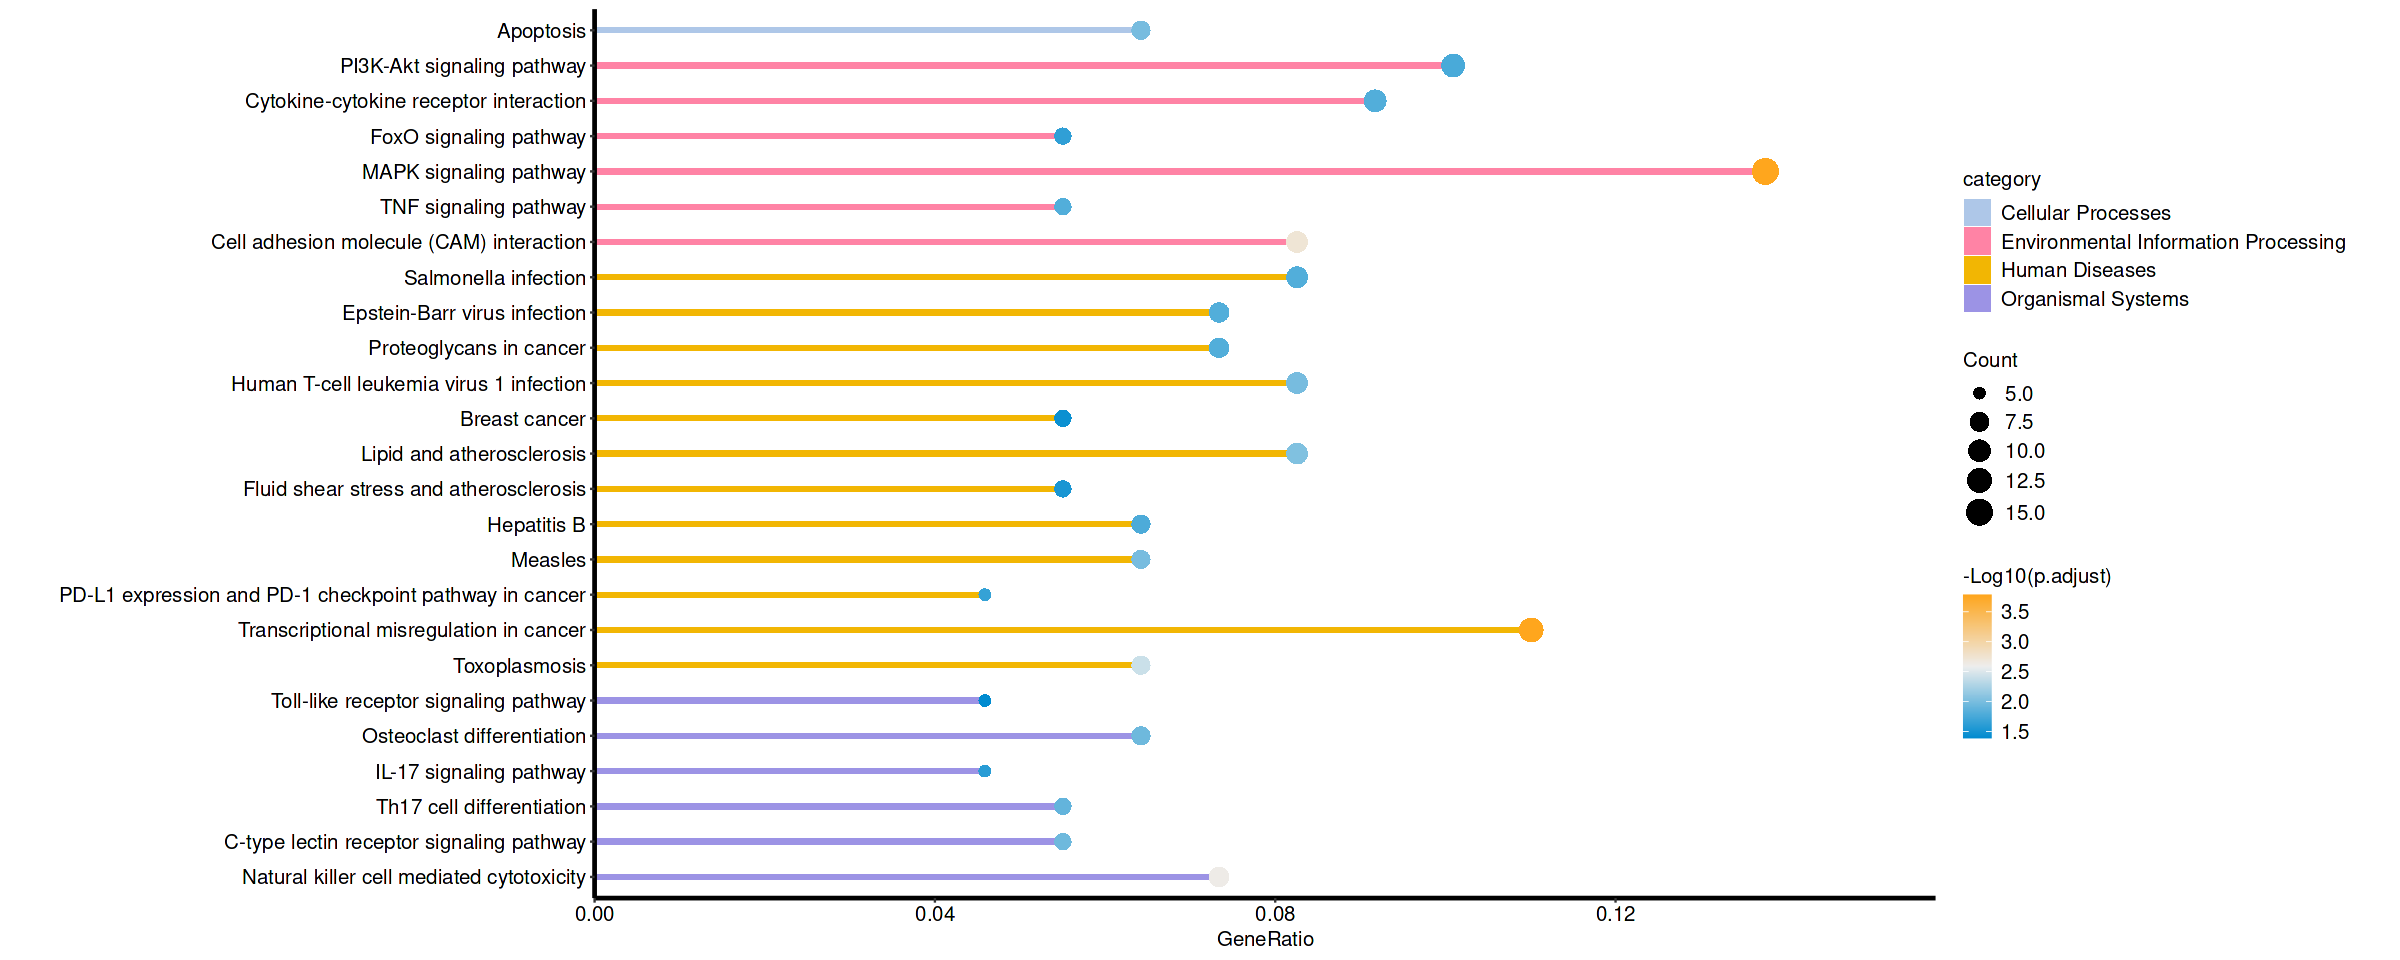

In [14]:
### KEGG
library(clusterProfiler)
library(org.Hs.eg.db)
library(tidyverse)

options(repr.plot.width = 20, repr.plot.height = 8)
GO_database <- 'org.Hs.eg.db'
KEGG_database <- 'hsa'
gene <- bitr(key.genes, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = GO_database)
KEGG <- enrichKEGG(gene = gene$ENTREZID,
                   keyType = "kegg",
                   organism = KEGG_database,
                   pAdjustMethod = "BH",
                   pvalueCutoff = 0.05,
                   qvalueCutoff = 0.05)
kegg_res <- setReadable(KEGG, OrgDb = org.Hs.eg.db, keyType="ENTREZID")
kegg_res <- data.frame(kegg_res)
kegg_res <- mutate(kegg_res , richFactor = Count / as.numeric(sub("/\\d+", "", BgRatio)))
kegg_res <- kegg_res [kegg_res$pvalue<0.1, ]


keggreasult <- kegg_res

keggreasult <- keggreasult %>% 
  arrange(richFactor) %>% 
  head(25) %>% 
  arrange(category) %>%
  mutate(Description = factor(Description, levels = rev(unique(Description))),
         y_value = 0.04)
keggreasult$GeneRatio <- sapply(strsplit(keggreasult$GeneRatio, "/"),
                                function(x) as.numeric(x[1]) / as.numeric(x[2]))


custom_colors <- colorRampPalette(c("#008bd0", "#eeeeee", "#ffa61d"))(100)
levelcolor <- c("#AEC7E8","#ff83a5","#f2b603", "#9c93e5", "#00a08f")


p <- ggplot(keggreasult, aes(x = Description, y = GeneRatio)) +
  coord_flip() +
  geom_col(aes(fill = category), width = 0.15) +
  geom_point(aes(size = Count, color = -log10(p.adjust)), shape = 16) +
  scale_size_continuous(range = c(3, 7)) +
  scale_fill_manual(values = levelcolor) +
  scale_color_gradientn(colors = custom_colors, 
                        values = scales::rescale(seq(0, 6, length.out = 100)),
                        name = "-Log10(p.adjust)") +
  scale_y_continuous(limits = c(0, max(keggreasult$GeneRatio) + 0.02),  
                     expand = c(0, 0)) +  
  labs(x = NULL, y = bquote("GeneRatio"), size = "Count") +
  theme(
    panel.background = element_rect(fill = NA),
    panel.grid = element_blank(),
    panel.border = element_blank(),
    axis.line = element_line(color = "black", linewidth = 1),
    axis.text = element_text(color = "black", size = 12),
    axis.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 12)
  )
p

ℹ GSVA version 2.0.7

ℹ Calculating GSVA ranks

ℹ kcdf='auto' (default)

ℹ GSVA dense (classical) algorithm

ℹ Row-wise ECDF estimation with Gaussian kernels

ℹ Calculating GSVA column ranks

ℹ Calculating GSVA scores

✔ Calculations finished



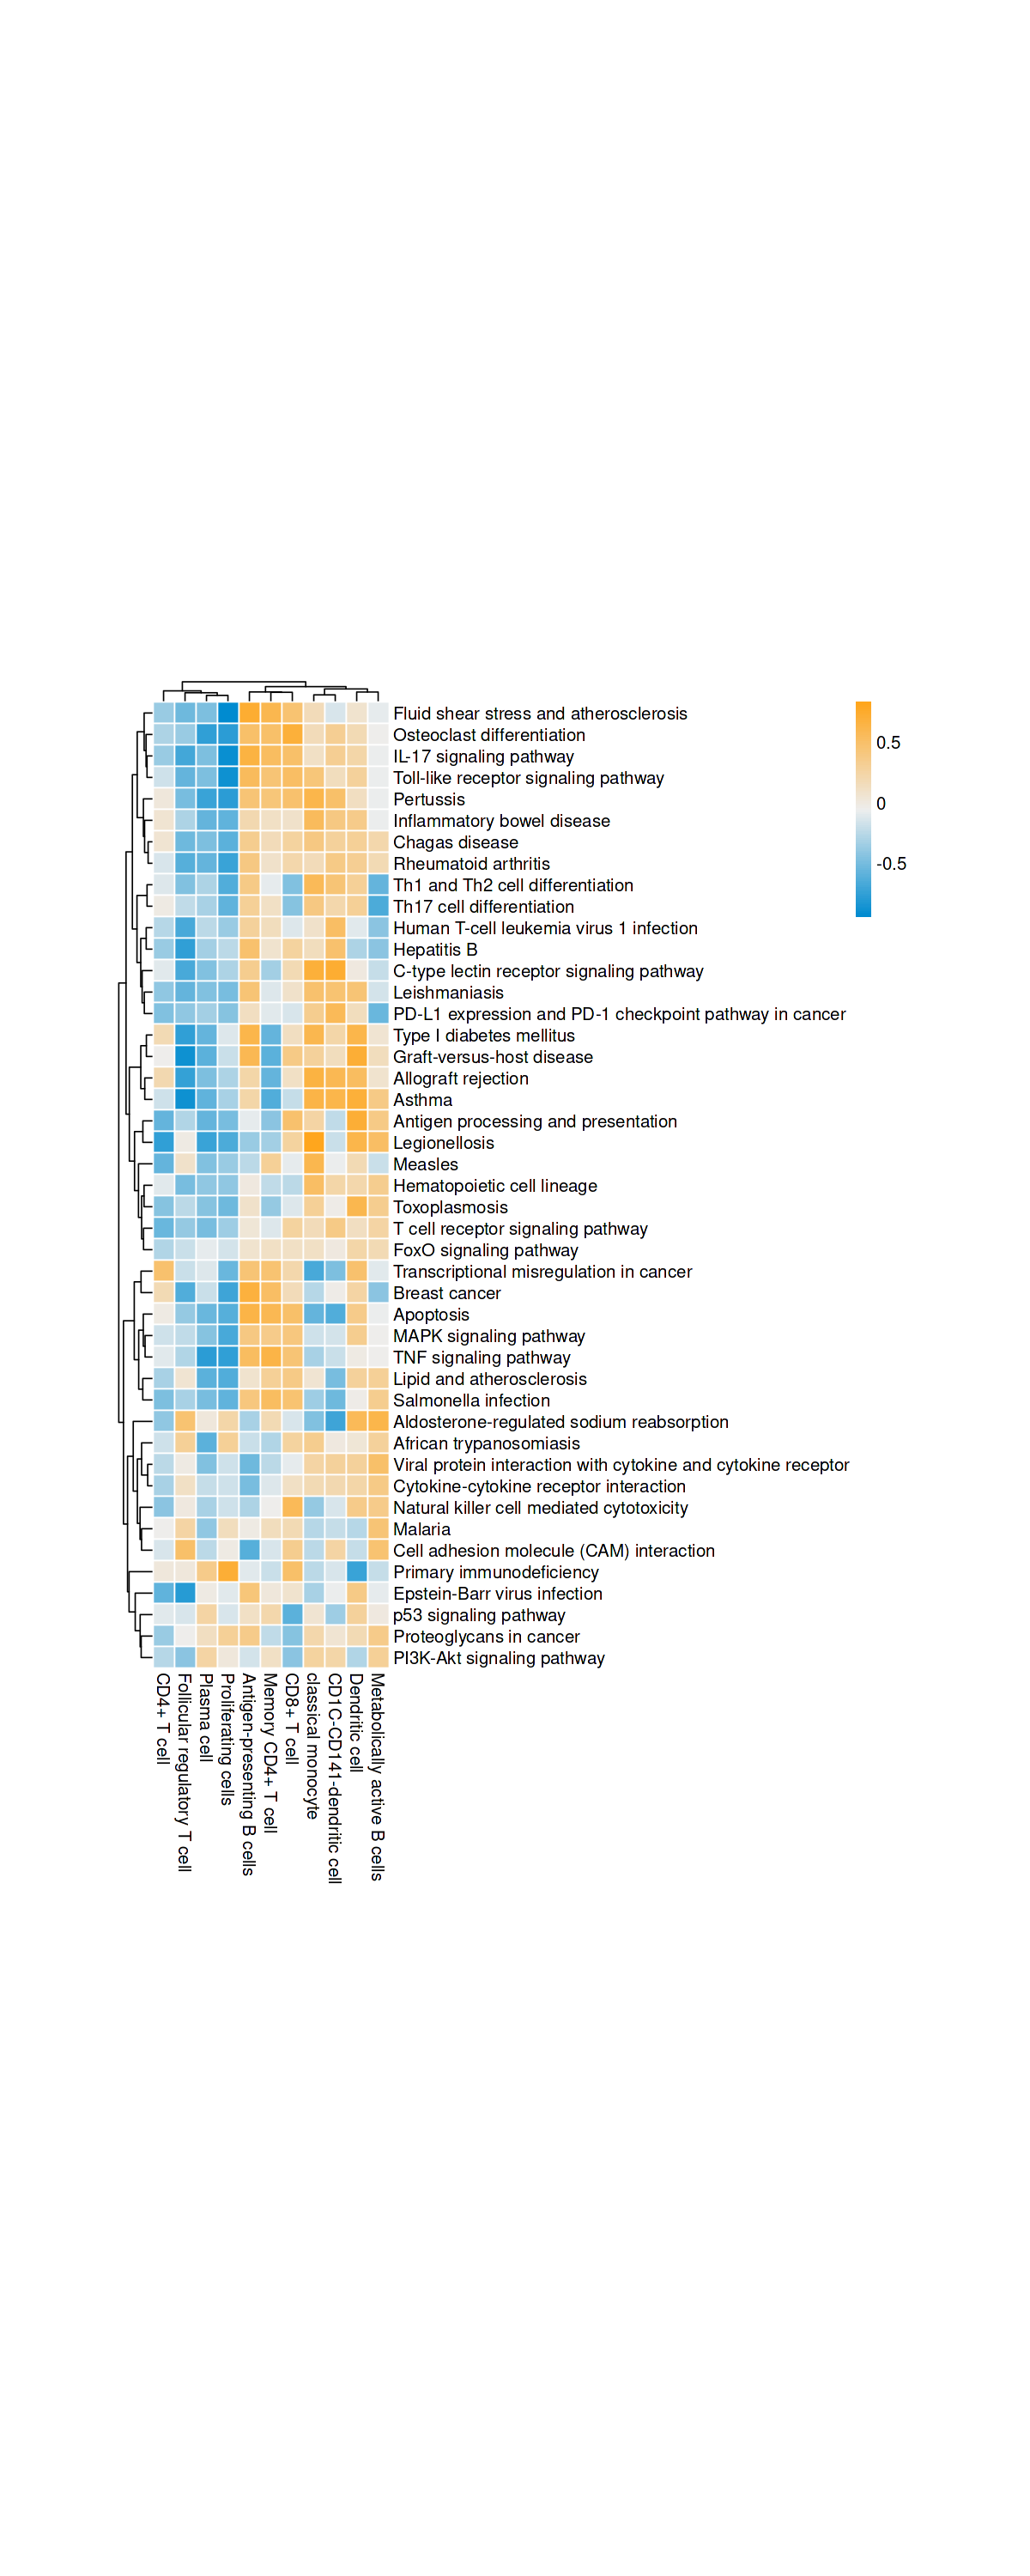

In [29]:
### GSVA
library(GSVA)
library(pheatmap)

options(repr.plot.width = 10, repr.plot.height = 25)
expr <- AverageExpression(scRNA, assays = "RNA", slot = "data")[[1]] 
expr <- expr[rowSums(expr)>0,] 
expr <- as.matrix(expr) 
expr <- expr[rownames(expr) %in% key.genes,] 
kegg_res <- setReadable(KEGG, OrgDb = org.Hs.eg.db, keyType="ENTREZID") 
genesets <- list()
for (i in seq_len(nrow(kegg_res))) {
  genesets[kegg_res[i,'Description']] <- as.list(strsplit(kegg_res[i,'geneID'],split='/'))
}
gsva.res <- gsva(gsvaParam(expr,genesets)) 

custom_colors <- colorRampPalette(c("#008bd0", "#eeeeee", "#ffa61d"))(100)

pheatmap(
  gsva.res,
  scale = "none",
  color = custom_colors,
  border_color = "white",
  cellwidth = 15, cellheight = 15,
  cluster_rows = T, 
  cluster_cols = T,
  treeheight_row = 20, treeheight_col = 10,
  fontsize = 12,
  show_rownames = T, 
  show_colnames = T
)

In [71]:
##Cellchat
library(CellChat)
library(tidyverse)
library(Seurat)
library(ComplexHeatmap)
library(ggalluvial)
library(presto)
library(NMF)

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [73]:
cellchat <- createCellChat(scRNA)
scRNA$cellType <- Idents(scRNA)
meta <- data.frame(cellType = scRNA$cellType, row.names =  Cells(scRNA))

cellchat <- addMeta(cellchat, meta = meta, meta.name = "cellType")

cellchat <- setIdent(cellchat, ident.use = "cellType") 

groupSize <- as.numeric(table(cellchat@idents)) 

CellChatDB <- CellChatDB.human

unique(CellChatDB$interaction$annotation)
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling")

cellchat@DB <- CellChatDB.use

cellchat <- subsetData(cellchat) 

cellchat <- identifyOverExpressedGenes(cellchat) 
cellchat <- identifyOverExpressedInteractions(cellchat)
#cellchat <- projectData(cellchat, PPI.human)

cellchat <- computeCommunProb(cellchat)

cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat@netP$pathways
levels(cellchat@idents) 

vertex.receiver = seq(1,4) 

cellchat@netP$pathways

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
The `meta.data` slot in the Seurat object is used as cell meta information 


Warning message in createCellChat(scRNA):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 
”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Antigen-presenting B cells, classical monocyte, Memory CD4+ T cell, Plasma cell, CD1C-CD141-dendritic cell, CD4+ T cell, CD8+ T cell, Dendritic cell, Follicular regulatory T cell, Proliferating cells, Metabolically active B cells 


[1] "Secreted Signaling"    "ECM-Receptor"          "Cell-Cell Contact"    
[4] "Non-protein Signaling"

The number of highly variable ligand-receptor pairs used for signaling inference is 593 
triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-12-09 11:40:58.247386]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-12-09 11:42:19.649012]"


[1] "MIF"      "CypA"     "GALECTIN" "BAFF"     "CXCL"     "CD70"    
 [7] "TGFb"     "ANNEXIN"  "CD137"    "IL16"     "IFN-II"   "TNF"     
[13] "IL1"      "IL6"      "VEGF"

[1] "Antigen-presenting B cells"   "classical monocyte"          
 [3] "Memory CD4+ T cell"           "Plasma cell"                 
 [5] "CD1C-CD141-dendritic cell"    "CD4+ T cell"                 
 [7] "CD8+ T cell"                  "Dendritic cell"              
 [9] "Follicular regulatory T cell" "Proliferating cells"         
[11] "Metabolically active B cells"

[1] "MIF"      "CypA"     "GALECTIN" "BAFF"     "CXCL"     "CD70"    
 [7] "TGFb"     "ANNEXIN"  "CD137"    "IL16"     "IFN-II"   "TNF"     
[13] "IL1"      "IL6"      "VEGF"

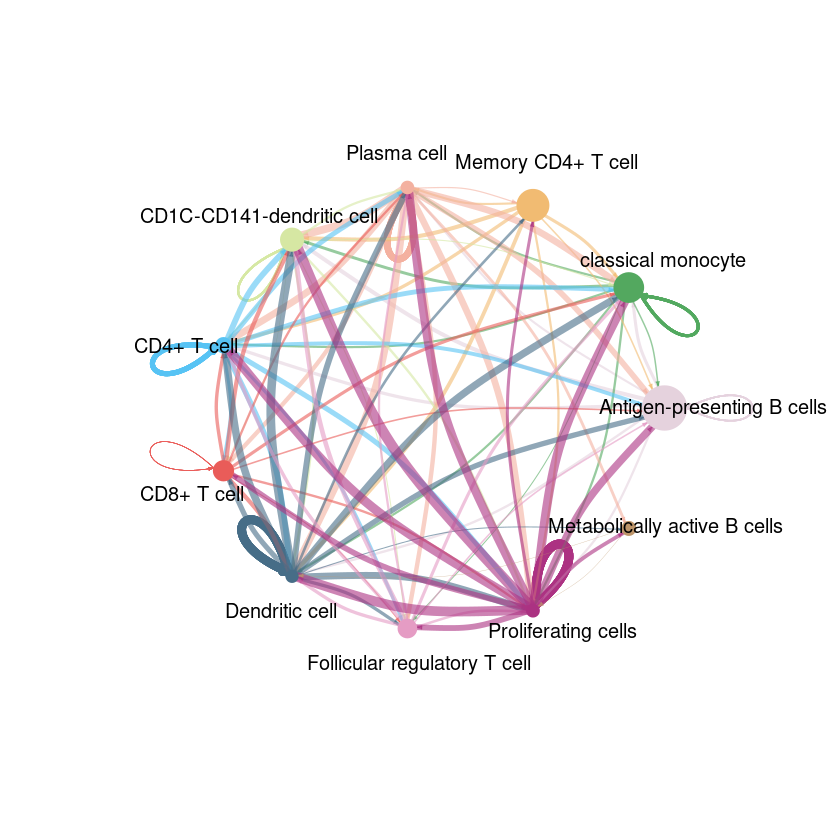

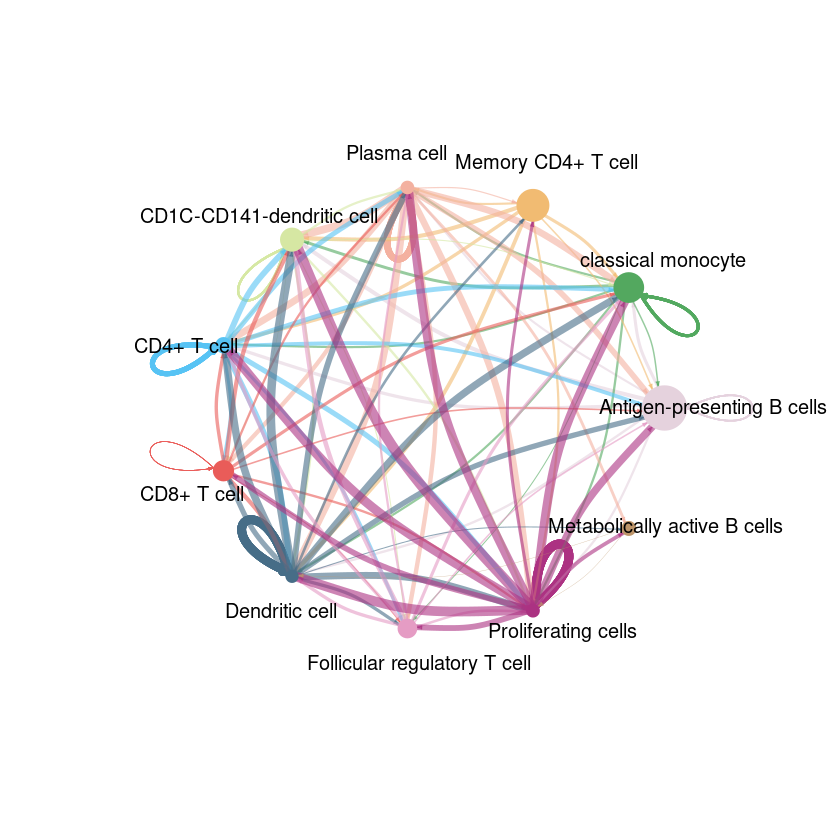

In [75]:
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, 
                 weight.scale = T, label.edge= F, title.name = "Strength of interactions",color.use = mycolors)

Do heatmap based on a single object 




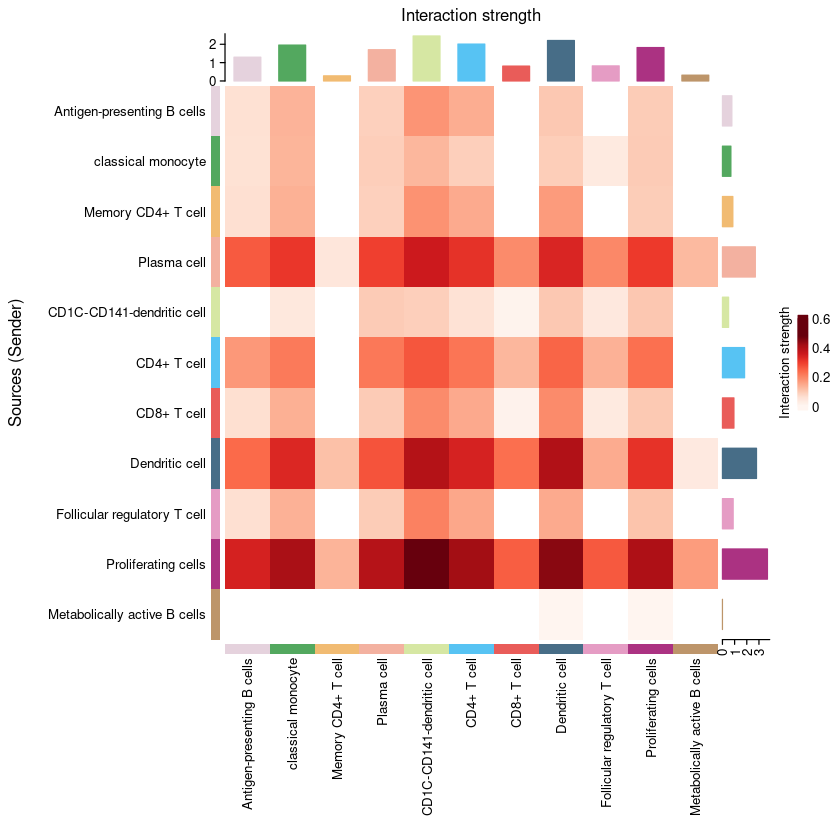

In [76]:
netVisual_heatmap(cellchat, measure = "weight", color.heatmap = "Reds",color.use = mycolors)

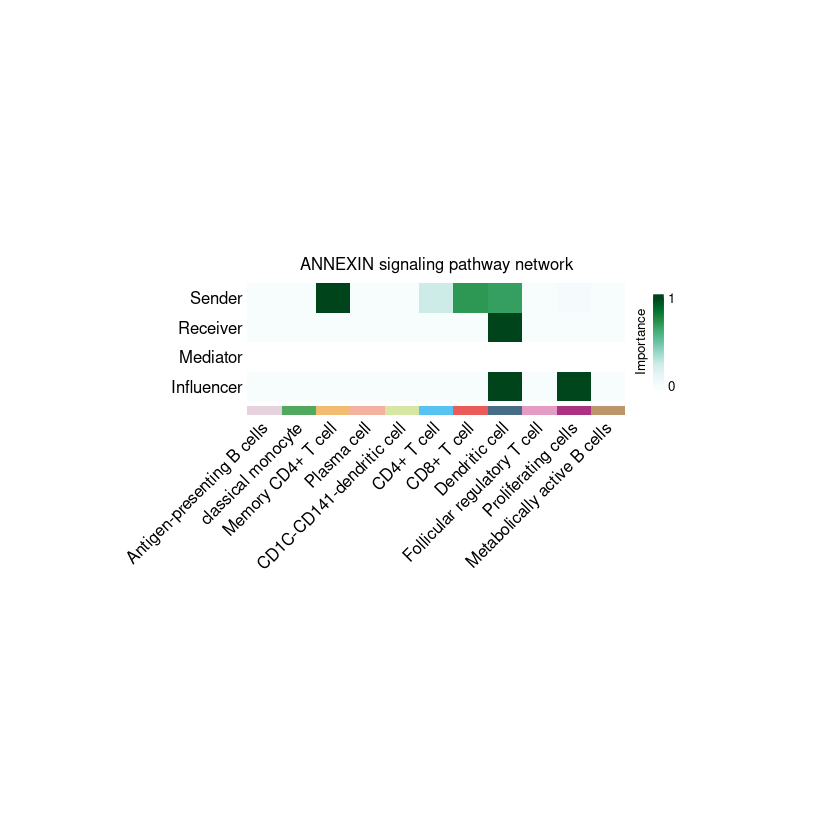

In [80]:
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, width = 8, height = 2.5, font.size = 10,color.use = mycolors)

Comparing communications on a single object 




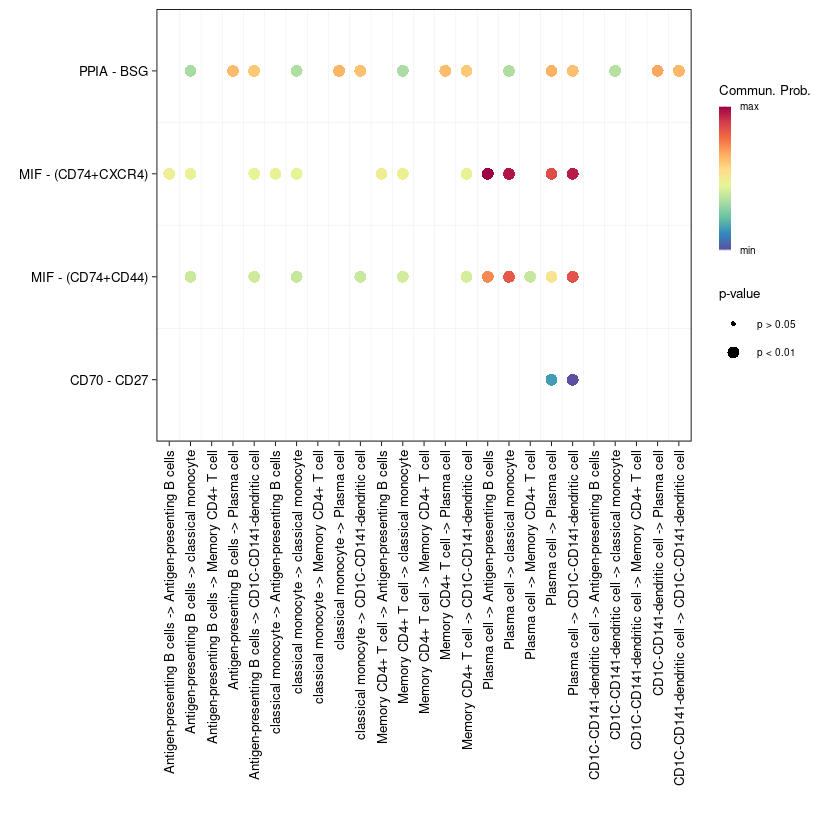

In [83]:
netVisual_bubble(cellchat, sources.use = 1:5, targets.use = c(1:5), remove.isolate = FALSE)

In [ ]:
K_incoming <- selectK(cellchat, pattern = "incoming")
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "incoming", k = 6)

Please make sure you have load `library(ggalluvial)` when running this function



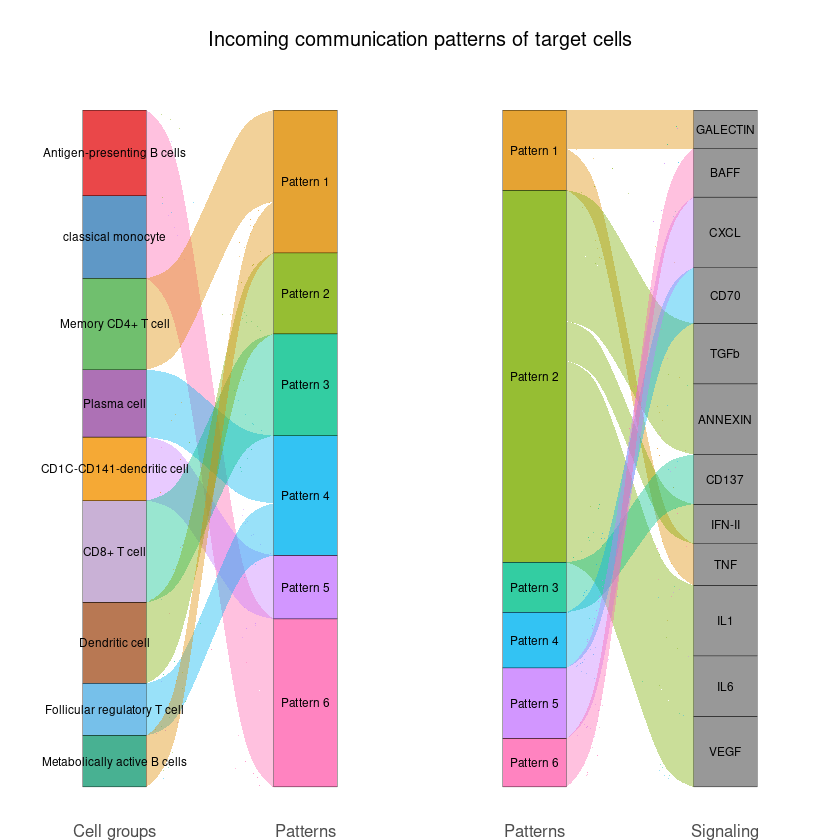

In [92]:
netAnalysis_river(cellchat, pattern = "incoming")

In [ ]:
K_outgoing <- selectK(cellchat, pattern = "outgoing")
cellchat <- identifyCommunicationPatterns(cellchat, pattern = "outgoing", k = 4)

Please make sure you have load `library(ggalluvial)` when running this function



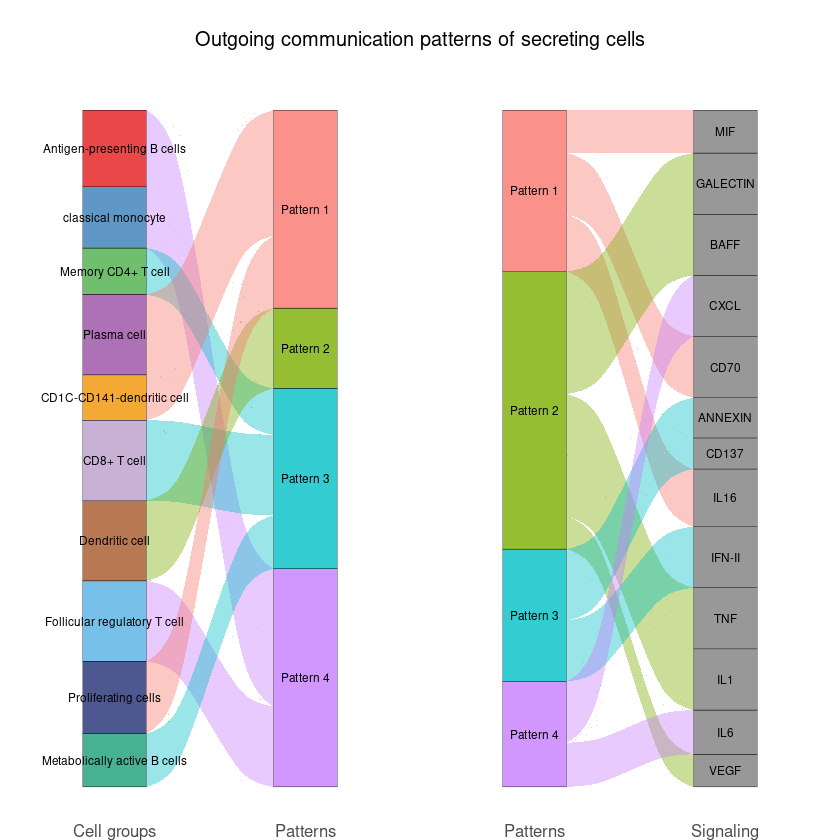

In [87]:
netAnalysis_river(cellchat, pattern = "outgoing")